# Le Boosting: un méta algorithme d'apprentissage

un méta-algorithme d'aprentissage est un algorithme permettant de combiner un ensemble d'instances d'un classifieur particulier. Le boosting est un de ces méta-algorithme:
- son principe est de combiner un ensemble de **classifieurs faibles** (classifiers en sous apprentissage avec performance supérieur au hasard)
- la construction des classifieurs qui sont combinés est itérative et dépend de la performance des précédents (chaque classifieur ajouté dans la combinaison tente d'améliorer l'ensemble précédent)

---

[AdaBoost](https://fr.wikipedia.org/wiki/AdaBoost) (ou adaptive boosting) est un méta-algorithme de boosting introduit par [Yoav Freund](https://fr.wikipedia.org/wiki/Yoav_Freund) et [Robert Schapire](https://fr.wikipedia.org/wiki/Robert_Schapire) en 19971. AdaBoost fonctionne pour les problèmes de classification binaires (2 classes) et améliore les performances de n'importe quel algorithme d'apprentissage. L'algorithme simplifié est le suivant:
1) soit un ensemble d'observations (exemples du corpus d'aprentissage), nous allons associer à chaque exemple un **poids** qui sera le même pour tous les exemples au début de l'algorithme
2) puis nous allons apprendre un classifieur faible (par exemple un arbre de décision à deux feuilles seulement) à partir de ces données
3) ce classifieur en sous-apprentissage va inévitablement commettre beaucoup d'erreurs sur ces propres données d'apprentissage: les exemples que le classifieur ne sait classer, nous allons les ***booster***, nous allons incrémenter leur **poids**.
4) nous allons alors apprendre un nouveau classifieur faible sur les mêmes données mais où certains exemples (ceux mal classés par le classieur précédent) comptent plus et le nouveau classifieur va s'attacher à bien classer en priorité ceux-là, il viendra donc corriger les erreurs du précédent.
5) boucle sur point **3** afin de générer un ensemble de classifieur
6) le classifieur de boosting final correspond à un vote de l'ensemble de ces classifieurs construits et permet de générer à partir d'un ensemble de classifieur faible un classifieur de boosting très fort.
    - chaque classifieur va voter pour pos avec 1 et neg avec -1
    - on va sommer le vote de tous les classifieur, si la somme est supérieure à zéro le boosting prédira pos sinon neg
    - le boosting n'est pas républicain: chaque classifieur peut avoir une voix au chapitre différente en fonction de sa performance individuelle son vote -1 ou +1 sera pondéré par un coefficient $\lambda$

---
Nous allons maintenant découvrir l'algorithme précisemment mais étape par étape au cours de ce TP:
- nous allons tester cet algorithme sur le corpus de [imdb.com](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) où la tâche binaire de classification est de prédire si la critique du film est positive ou non
- nous allons choisir un arbre de décision à deux feuilles, autement appelé en anglais *decision stumps*, donc un arbre qui fait un seul test binaire, ici le test binaire sera la présence d'un mot ou non dans la critique du film
- l'algorithme de boosting demande que l'on prédise la valeur -1 ou +1 selon la classe: mettons -1 pour négatif et +1 pour positif

## ÉTAPE 1: préparation des données


### 1) chargement des données de imdb

In [40]:
import pandas as pd
data_train = pd.read_json('imdb-trn.json')
data_train.columns=['classe','critique']
data_test = pd.read_json('imdb-tst.json')
data_test.columns=['classe','critique']



data_train=data_train.sample(frac=0.1) #le corpus d'aprentissage contient 25000 exemples, on peut réduire un peu si le code est trop lent

data_train.head()


,classe,critique
22772,neg,Why on earth is Colin Firth in this pointless ...
9971,pos,"This isn't the best Bigfoot ever made, but by ..."
16988,neg,"I agree with the previous comment, the beginni..."
17256,neg,"For the big thinkers among us, ""The Intruder"" ..."
21258,neg,The Earth is destined to be no more thanks to ...


### 2) nettoyage des données
- pour assurer une meilleure généralisation nous allons faire un nettoyage minimal des donnés
- on pourrait par exemple *tokenizer* et lémmatiser les mots proprements (par exemple avec [nltk](https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells)) 
- ici ce n'est pas l'objectif du TP, on peut se contenter de la question suivante:
- **QUESTION**: supprimer la ponctuation, les mots contenant des chiffres et passez tous les mots en bas de casse

In [41]:
data_train['critique'] = data_train['critique'].str.replace('[^\w\s]','', regex=True).str.replace('\w*\d+\w*','', regex=True).str.lower()

data_train.head()

,classe,critique
22772,neg,why on earth is colin firth in this pointless ...
9971,pos,this isnt the best bigfoot ever made but by th...
16988,neg,i agree with the previous comment the beginnin...
17256,neg,for the big thinkers among us the intruder is ...
21258,neg,the earth is destined to be no more thanks to ...


pour faciliter le traitement ultérieur (vérifier dans une critique si un mot est utilisé ou non par l'auteur) nous allons utiliser la structure de données suivante: 
1) **critique_train/test**: une liste de dictionnaire, chaque dictionnaire contiendra comme entrées les mots utilisés dans la critique correspondante. 
2) **classes_train/test**: la liste des classes (-1 ou -1) pour chaque critique

In [42]:
from collections import Counter
critiques_train =  [dict(Counter(critique.split())) for critique in data_train['critique'].to_list()]
critiques_test =  [dict(Counter(critique.split())) for critique in data_test['critique'].to_list()]
print(data_train['critique'].iloc[0],' -> ',critiques_train[0])
classes_train = [1 if opinion == 'pos' else -1 for opinion in data_train['classe'].to_list()]
classes_test = [1 if opinion == 'pos' else -1 for opinion in data_test['classe'].to_list()]
print(data_train['classe'].iloc[0:5],' -> ',classes_train[0:5])

why on earth is colin firth in this pointless film has he really been that strapped for cashbr br the film isnt clear on what it wants to be about grief exotic places ghosts a vehicle for mr darcy its a muddled muddy messbr br there seems to be some sort of idea that italy must be good in itself and that italian has something to offer as a language  but in the end the girls just want to go back to yanklandbr br there are pointless episodes on the beach in churches on busy roads  but what it is all about or why anybody should care simply isnt clearbr br there was also a yank woman in the film it wasnt clear what here job was but she seemed only to be there to make vapid inappropriate and maudlin comments to the girl was it supposed to be about paedophilliabr br a pretty dreadful mess all in all i gave it  rather than  because it doesnt have the charm of an utterly ghastly film  ->  {'why': 2, 'on': 4, 'earth': 1, 'is': 2, 'colin': 1, 'firth': 1, 'in': 6, 'this': 1, 'pointless': 2, 'film

## ÉTAPE 2: le classifieur faible
- ce classifieur sera une arbre de décision à 2 feuilles appelé *decision stump*
- le principe de boosting étant de pondérer (booster) les exemples d'apprentissage ,il nous faut un vecteur de poids et que notre classifieur le prenne en compte pour calculer l'erreur qu'il commet

### 1) Initialisation des poids
- le boosting commence en considérant chaque exemple d'apprentissage équivalent en leur attribuant un poids identique
- l'ensemble des poids doit sommer à 1 pour se conformer à une distribution de probabilité

In [43]:
import numpy as np
weigths = np.ones(len(critiques_train),'float')/len(critiques_train)
weigths

array([0.0004, 0.0004, 0.0004, ..., 0.0004, 0.0004, 0.0004])

### 2) structure du classifeur (*decision stump*)
**QUESTION**: écrivez le code de la méthode ***fit(..)*** du classifieur dont la description est donnée ci-après, cette fonction permet pour un test binaire connu (un mot) de calculer la valeur des autres attributs de la classe

In [44]:
class decision_stump:
    binary_rule=None                 # une string stockant le test binaire, ici un mot de la critique
    yes_branch_prediction:float=None # prediction -1 ou +1 si le mot est présent dans la critique
    no_branch_prediction:float =None # prediction -1 ou +1 si le mot est absent de la critique
    global_error: float=None         #taux d'erreur global du classifieur sur le corpus d'apprentissage
    def __init__(self,word):
        self.binary_rule=word        #le constructeur prend en argument le mot qui servira de test binaire, la valeur des autres attributs seront estimés sur le corpus d'apprentissage
       
    
    """
    fit(...) 
    Args:
        list_of_samples: la liste des dictionnaires représentant les mots de chaque critique
        list_of_classes: la liste des classes de chaque critique (-1 ou +1 représentant neg ou pos)
        weigths        : liste de poids de boosting actuel associé à chaque example 
    do:
        renseigne les champs: yes_branch_prediction, no_branch_prediction et global_error
    Returns:
        l'erreur globale du classifieur faible
    """
    def fit(self,list_of_samples,list_of_classes,weigths):
        yes_nb_pos=0
        yes_nb_neg=0
        no_nb_pos=0
        no_nb_neg=0
        for i in range(len(list_of_samples)):
            if self.binary_rule in list_of_samples[i]:
                if list_of_classes[i]==1:
                    yes_nb_pos+=weigths[i]
                else:
                    yes_nb_neg+=weigths[i]  
            else:
                if list_of_classes[i]==1:
                    no_nb_pos+=weigths[i]  
                else:
                    no_nb_neg+=weigths[i]
        if yes_nb_pos>yes_nb_neg:
            self.yes_branch_prediction=1 
        else :
            self.yes_branch_prediction=-1
        if no_nb_pos>no_nb_neg:
            self.no_branch_prediction=1 
        else :
            self.no_branch_prediction=-1
            
        self.global_error = yes_nb_neg + no_nb_pos
        
        return self.global_error
    
    """
    predict(...) 
    Args:
        list_of_samples: la liste des dictionnaires représentant les mots de chaque critique        
    do:
        fait une prédiction -1 ou +1 pour chaque exemple
    Returns:
        une liste de prediction
    """
    def predict(self,list_of_samples):        
        if self.yes_branch_prediction is not None and self.no_branch_prediction is not None:
            predictions=[]
            for sample in list_of_samples:
                if self.binary_rule in sample:
                    predictions.append(self.yes_branch_prediction)
                else:
                    predictions.append(self.no_branch_prediction)
            return predictions
        else:
            return []
    
    #renvoi l'erreur du classifieur
    def error(self): 
        return self.global_error 
    def __str__(self):
        return f'exists the word "{self.binary_rule}" error={self.global_error}'
        

estimons un classifieur arbitraire avec ***fit***:

In [45]:
clf = decision_stump('great')
error=clf.fit(critiques_train,classes_train,weigths)
print('great=',error)

great= 0.4116000000000051


### 3) faire de la prédiction
- le classifieur produit doit pouvoir faire de la prédiction sur des données arbitraire une fois appris

**QUESTION** complétez la méthode ***predict*** qui permet de faire de la prédiction

testons la:

In [46]:
prediction = clf.predict(critiques_train)

from sklearn.metrics import classification_report, accuracy_score
print(1-accuracy_score(classes_train,prediction),'==',clf.error())
print(classification_report(classes_train,prediction,digits=5))

0.41159999999999997 == 0.4116000000000051
              precision    recall  f1-score   support

          -1    0.56267   0.84044   0.67406      1266
           1    0.66831   0.32982   0.44167      1234

    accuracy                        0.58840      2500
   macro avg    0.61549   0.58513   0.55786      2500
weighted avg    0.61481   0.58840   0.55935      2500


## ÉTAPE 3: l'algo de boosting
- d'habitude on choisissait le meilleur arbre selon le critère de l'entropie
- mais ici notre arbre complet a juste un nœud donc on peut tous les évaluer et choisir le meilleur de manière objective:
- $ \rightarrow $ celui qui minimise l'erreur sur le corpus d'apprentissage
---
### 1) liste des test binaires
- **QUESTION**: dressez la liste (**allwords**) de tous les test binaires possibles (tous les mots)
- **ATTENTION** la liste est longue, filtrer la pour ne conserver que les mots ayant été vus dans au moins X documents (ça s'appelle en anglais *cutoff*) prenez par exemple X=100 pour que votre futur code ne soit pas trop lent

In [47]:
X = 100
words_appearance_dict = {}
for critique in critiques_train:
    for word in critique.keys():
        if word in words_appearance_dict:
            words_appearance_dict[word]+=1
        else:
            words_appearance_dict[word]=1
            
allwords = [word for word in words_appearance_dict.keys() if words_appearance_dict[word]>X]
print(len(allwords))
print(allwords[0:100])

500
['why', 'on', 'is', 'in', 'this', 'film', 'has', 'he', 'really', 'been', 'that', 'for', 'br', 'the', 'isnt', 'what', 'it', 'wants', 'to', 'be', 'about', 'a', 'its', 'there', 'seems', 'some', 'sort', 'of', 'idea', 'must', 'good', 'itself', 'and', 'something', 'as', 'but', 'end', 'girls', 'just', 'want', 'go', 'back', 'are', 'all', 'or', 'should', 'care', 'simply', 'was', 'also', 'woman', 'wasnt', 'here', 'job', 'she', 'seemed', 'only', 'make', 'girl', 'supposed', 'pretty', 'i', 'rather', 'than', 'because', 'doesnt', 'have', 'an', 'best', 'ever', 'made', 'by', 'movies', 'quality', 'stuff', 'action', 'humor', 'decent', 'used', 'so', 'which', 'overall', 'movie', 'worth', 'watch', 'if', 'you', 'fan', 'need', 'better', 'not', 'dont', 'acting', 'may', 'expect', 'find', 'like', 'more', 'bit', 'characters']


### 2) structure de l'algo de boosting

- voici la structure en classe de l'algo de boosting observez là et lisez les commentaires

In [48]:
import tqdm

class Adaboost:
    allwords=None         # liste des tests binaires possibles (liste de mots)
    weigths=None          # vecteur de poids associés à chaque exemples
    weak_learners = []    # liste des classifieurs faibles (décision stumps) appris à chaque itération de l'algo de boosting
    poids_de_vote = []    # poids de vote de chacun des weak_learners dans la décision finale
    n_iteration = 1       # nombre d'itération de l'algorithme: nombre de décision stumps à construire et à faire voter
     

    def __init__(self,allwords,n_iter=1): #constructeur qui prend en paramètre la liste des test binaires possibles et le nombre d'itération
        self.allwords=allwords
        self.n_iteration=n_iter
    """
    round(...) 
    Args:
        list_of_samples: la liste des dictionnaires représentant les mots de chaque critique
        list_of_classes: la liste des classes de chaque critique (-1 ou +1 représentant neg ou pos)
        weigths        : liste de poids de boosting actuel associé à chaque example
        allwords       : liste de tous les mots possibles
    do:
        teste tous les classifieurs possibles et trouve le meilleur 
    Returns:
        le meilleur classifieur
    """
    def round(self,list_of_samples,list_of_classes):
        bestclf = None
        
        for word in self.allwords:
            clf = decision_stump(word)
            error=clf.fit(list_of_samples,list_of_classes,self.weigths)
            if bestclf is None or error<bestclf.error():
                bestclf=clf
                
        return bestclf

    """
    fit(...) 
    Args:
        list_of_samples: la liste des dictionnaires représentant les mots de chaque critique
        list_of_classes: la liste des classes de chaque critique (-1 ou +1 représentant neg ou pos)            
    do:
        apprends les n_iteration decision stumps
    Returns:
        None
    """
    def fit(self,list_of_samples,list_of_classes):
        self.weigths = np.ones(len(list_of_samples),'float64')/len(list_of_samples)

        for i in tqdm.tqdm(range(self.n_iteration)):
            self.weak_learners.append(self.round(list_of_samples,list_of_classes))
            
            e = self.weak_learners[-1].error()
            
            alpha = 0.5*np.log((1-e)/e)
            self.poids_de_vote.append(alpha)
            Z = 2*np.sqrt(e*(1-e))
            
            for j in range(len(list_of_samples)):
                y = list_of_classes[j]
                h = self.weak_learners[-1].predict([list_of_samples[j]])[0]
                
                self.weigths[j]=self.weigths[j]*np.exp(-alpha*y*h)/Z
       

        """
        predict(...) 
        Args:
            list_of_samples: la liste des dictionnaires représentant les mots de chaque critique
            n              : number of weak classifier to use for prediction, if None, use all
        do:
            prédit la classe -1 ou 1 de chaque exemple
        Returns:
            liste de prédictions
        """
    def predict(self,list_of_samples,n=None):       
        if n is None:
            n=len(self.weak_learners)
            
        predictions = np.zeros(len(list_of_samples))
        for i in range(n):
            predictions+=np.array(self.weak_learners[i].predict(list_of_samples))*self.poids_de_vote[i]
        
        predictions = np.sign(predictions)
        return predictions
                       
        
        
    def __str__(self):
        chaine="n_iter="+str(self.n_iteration)+"\n"
        for wl in self.weak_learners:
            chaine+=str(wl)+'\n'
        return chaine
    

- **QUESTION**: écrivez le code de la fonction ***round()*** qui teste l'ensemble des *decision stump* (pour chaque mot possible) et renvoi le meilleur (celui dont l'erreur globale est la plus faible)

**ASTUCE**: penser à tqdm pour afficher une barre de progression, si le temps estimé est trop long, augmentez le *cutoff* précédent

Maintenant testons votre fonction: le meilleur classifieur à l'iter 1 est...:

In [49]:
adatest = Adaboost(allwords,1)
adatest.fit(critiques_train,classes_train)
print(adatest)

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

n_iter=1
exists the word "great" error=0.4116000000000051


### 4) organisons la boucle de boosting
- la fonction ***fit*** va implémenter la boucle principale de l'algorithme  
    1) entrainer un classifieur faible (decision stumps) avec la dictribution de poids actuelle
    2) nous devons calculer le poids du vote ($\alpha$) du classifieur courant dans la combinaison finale
    3) nous devons modifier les poids de chacun des exemples d'apprentissages en fonction des erreurs commises par le decision stump précédent 
    4) reboucler sur 1 tant que le nombre de classifieur faible entrainés est < à n_iteration
    
**QUESTION** complétez la méthode ***fit*** de la classe booting
1) calculer le poids de vote ($\alpha$)
    - $\alpha = \frac{1}{2}ln(\frac{1-\epsilon}{\epsilon})$ ou $\epsilon$ est l'erreur commise par le classifieur
    - mettez à jour ***poids_de_vote***

2) mettez à jour les poids de ***weights***
    - si weights = W
    - $W_{t+1}(i)=\frac{W_t(i)e^{-\alpha_t*y_i*h_t(x_i)}}{Z_t}$
    - $Z_t$ est le coeff de normalisation $Z_t=2\sqrt{\epsilon_t(1-\epsilon_t)}$
    - où $y_i$ est la vrai classe (-1 ou +1) de l'example et $h_t(x_i)$ est la prédiction du classifieur (decision stump courant)

In [50]:
ada = Adaboost(allwords,50)
ada.fit(critiques_train,classes_train)
print(ada)

100%|██████████| 50/50 [00:20<00:00,  2.41it/s]

n_iter=50
exists the word "great" error=0.4116000000000051
exists the word "great" error=0.4116000000000051
exists the word "and" error=0.45292532862420953
exists the word "excellent" error=0.45072521390939607
exists the word "and" error=0.46038649688168914
exists the word "love" error=0.4553678988361326
exists the word "as" error=0.46873202383229945
exists the word "very" error=0.46970687666308264
exists the word "and" error=0.47198860536057285
exists the word "wonderful" error=0.4632700131505899
exists the word "and" error=0.4679007984218624
exists the word "best" error=0.46615554277407784
exists the word "and" error=0.47802538958878893
exists the word "excellent" error=0.46835585381648703
exists the word "and" error=0.4725094597247794
exists the word "wonderful" error=0.4714849132207457
exists the word "and" error=0.474384053969164
exists the word "beautiful" error=0.47240897615450156
exists the word "and" error=0.4763994746791827
exists the word "amazing" error=0.47439219312171427


### 5) faire de la prediction
1) chaque exemple pour lequel nous voulons prédire sa classe devra passer dans chaque classifier faible qui fera une prédiction de -1 ou 1 pondérée par le poids de vote $\alpha$
2) nous ferons la somme de tous ces votes:
    - si cette somme est >= 0 nous prédisons 1, sinon -1
3) afin d'évaluer la qualité du boosting en fonction du nombre de decision stumps, nous ajoutons un paramètre ***n*** qui permettra de prédire qu'en utilisant les n premiers classifieurs sans avoir à réapprendre
    
**QUESTION** codez la méthode ***predict*** de la classe booting

testons la sur l'apprentissage

In [51]:
predictions_boost=ada.predict(critiques_train)

from sklearn.metrics import classification_report
print(classification_report(classes_train,predictions_boost,digits=5))

              precision    recall  f1-score   support

          -1    0.61418   0.80727   0.69761      1266
           1    0.70813   0.47974   0.57198      1234

    accuracy                        0.64560      2500
   macro avg    0.66116   0.64350   0.63480      2500
weighted avg    0.66056   0.64560   0.63560      2500


sur le test

In [52]:
predictions_boost_test=ada.predict(critiques_test)

from sklearn.metrics import classification_report
print(classification_report(classes_test,predictions_boost_test,digits=5))

              precision    recall  f1-score   support

          -1    0.58079   0.84048   0.68691     12500
           1    0.71147   0.39336   0.50662     12500

    accuracy                        0.61692     25000
   macro avg    0.64613   0.61692   0.59677     25000
weighted avg    0.64613   0.61692   0.59677     25000


### 6) voir l'effacité de la combinaison

**QUESTION**
- obtenez le résultats en combinant 1, puis 2, puis n classifieurs faibles
- tracer la courbe, du f1_score en fonction du nombre de classifieurs faibles sur le train et le test

In [53]:
predictions_boost_test_list = [ada.predict(critiques_test,n=i) for i in range(1,51)]
predictions_boost_train_list = [ada.predict(critiques_train,n=i) for i in range(1,51)]

reports_test = [classification_report(classes_test,predictions_boost_test_list[i],output_dict=True) for i in range(len(predictions_boost_test_list))]
reports_train = [classification_report(classes_train,predictions_boost_train_list[i],output_dict=True) for i in range(len(predictions_boost_train_list))]

f1_scores_test = [report['weighted avg']['f1-score'] for report in reports_test]
f1_scores_train = [report['weighted avg']['f1-score'] for report in reports_train]

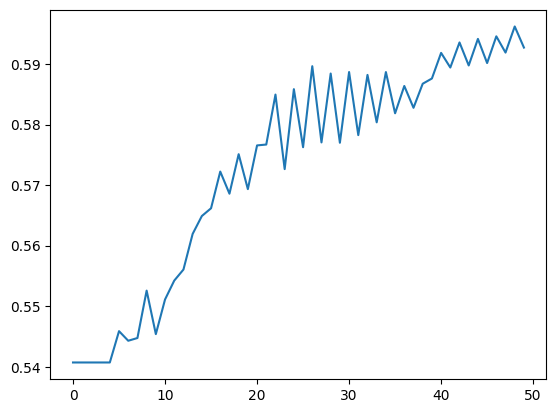

In [54]:
import matplotlib.pyplot as plt

plt.plot(f1_scores_test,label='test')

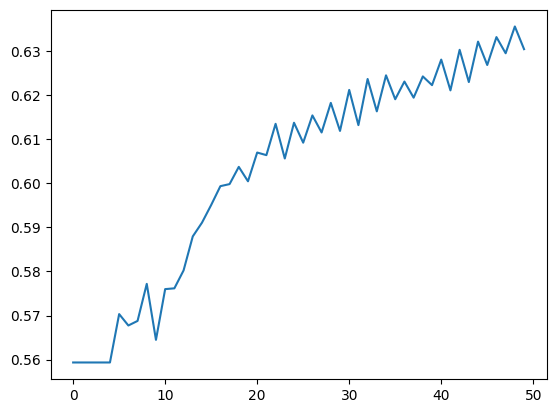

In [55]:
plt.plot(f1_scores_train,label='train')